In [1]:
from functools import partial
# import sys
# sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import KBio


In [2]:
# p = KBio.Polynomial(degree = 3, c=0.1)
p = KBio.Gaussian(sigma=1e-2)

In [3]:
np.random.seed(7)

We'll run our simulation with a time step (Euler method) of 0.01, 5% initial infection (this is quite high, but avoids stability issues **and** makes for way more awesome plots).

In [6]:
beta = 4e-1
gamma = 1e-1
T_final = 3e1
dt = 1e-2  # for Euler step
data = KBio.rectangular_grid([0], [3e1], [30 + 1])
sim = KBio.SIS_sim(dt=dt, T_final=T_final, beta=beta, gamma=gamma, I0 = 5, S0 = 95, euler=False)
sim(data, forcing = lambda x: 1.8e-1*np.sin(0.01 + 0.9*x))

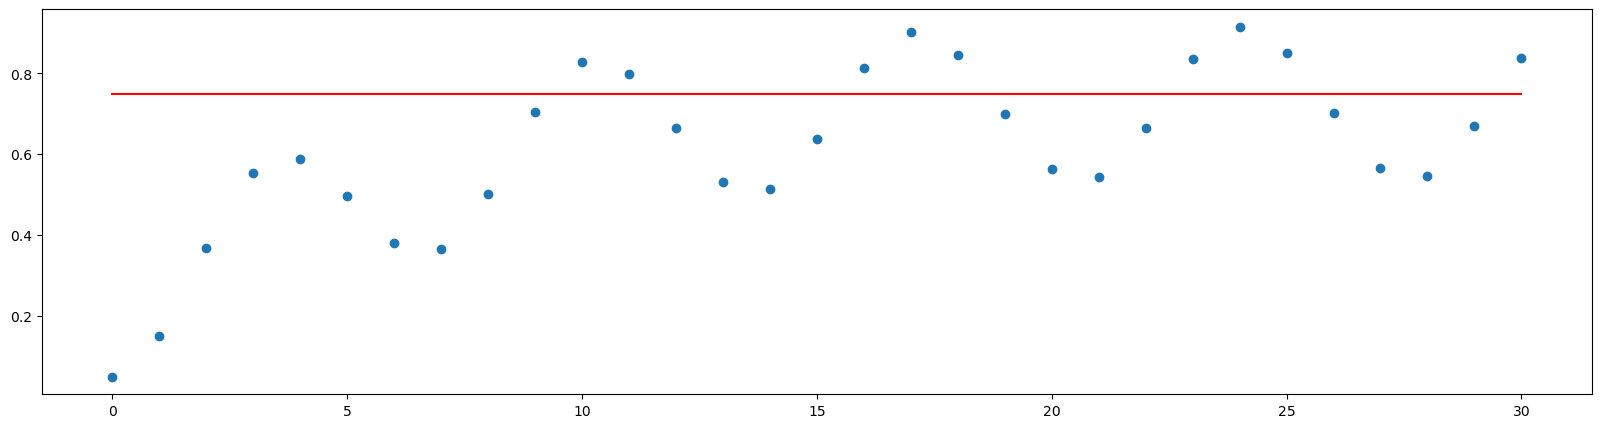

In [7]:
plt.figure(figsize=(20,5))
plt.plot(data.grid_tensors[0], data.grid_tensors_values, 'o')
# Put a vertical line at asymptotic steady state under no perturbation
steady_state = sim.asymptotic_steady_state() # 1 - 1/R0
# horizontal line from 0 to T_max at the asymptotic steady state
plt.plot([0, np.max(data.grid_tensors[0])], [steady_state, steady_state], 'r')

Now let's generate a small data set of 200 points, with 100 trajectories, and plot it. We'll sample the forcing functions as sinusoids with random frequencies and amplitudes, and constants. 

<!-- 80 trajectories will be with sinusoidal forcing, and 20 will be constant. -->

In [13]:
def oscillatory_forcing(A, omega, phi, t):
    return A*np.sin(omega + phi*t) * np.minimum(1, t/10)

def constant_forcing(A, t):
    return A * np.minimum(1, t/10)

In [14]:
n_samples_oscillatory = 10
# use log-uniform distribution to generate amplitudes
amplitudes = 10 ** (np.random.uniform(-3, -2.5, n_samples_oscillatory))

# use uniform distribution to generate frequencies
shifts = np.random.uniform(0, np.pi, n_samples_oscillatory)
print(shifts)
frequencies = np.random.uniform(1, 6, n_samples_oscillatory)
forcing_functions = [partial(oscillatory_forcing, amplitude, shift, frequency) for amplitude, shift, frequency in zip(amplitudes, shifts, frequencies)]
grids_oscillatory = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_oscillatory)]
for grid, amplitude, shift, frequency, fn in zip(grids_oscillatory, amplitudes, shifts, frequencies, forcing_functions):
    sim(grid, forcing = fn)

[2.13386397 2.52502065 1.19676187 0.20714514 0.9052361  2.85757234
 0.67036986 1.42038932 2.92546999 0.07822323]


Our oscillatory forcing function is of the form
$$
f(t) = \min(1, t / 10) A \sin(\omega t + \phi)
$$

So by day 10, the forcing function will be at its full amplitude. This avoids issues where the forcing function overpowers the dynamics of the system and makes the trajectories non-physical. 

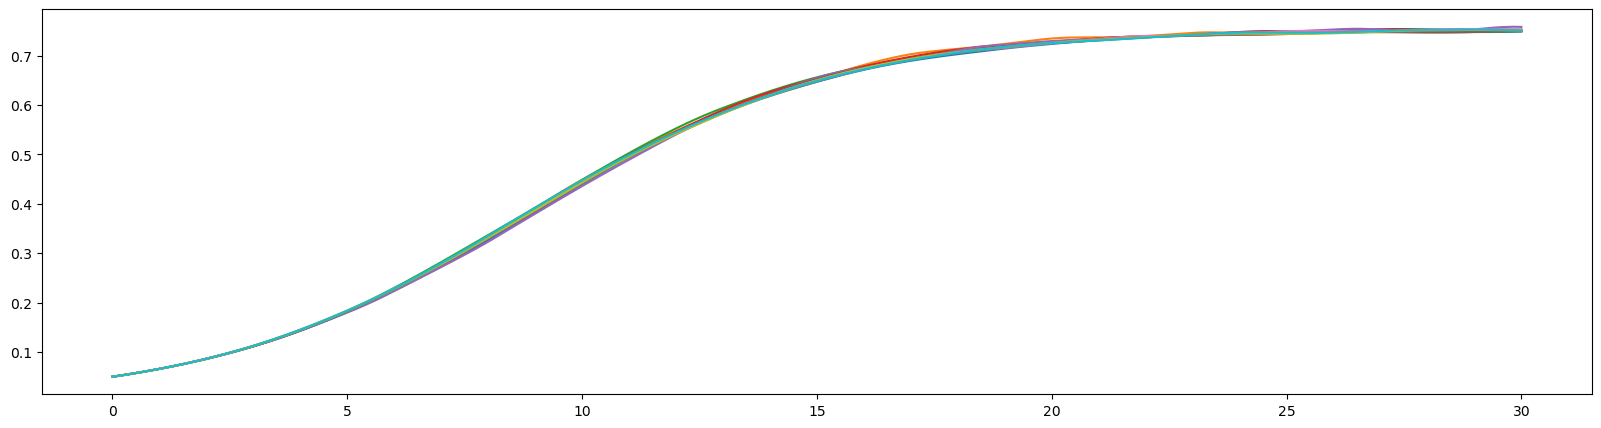

In [15]:
plt.figure(figsize=(20,5))
for grid in grids_oscillatory:
    plt.plot(grid.grid_tensors[0], grid.grid_tensors_values)

In [16]:
n_samples_constant = 2
grids_constant = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_constant)]

constant_values = np.random.normal(0, 1e-4, n_samples_constant)
functions_constant = [partial(constant_forcing, constant_value) for constant_value in constant_values]
for grid, constant_value, fn in zip(grids_constant, constant_values, functions_constant):
    sim(grid, forcing = fn)

In [17]:
constant_values

array([-4.53860299e-06, -1.45067870e-04])

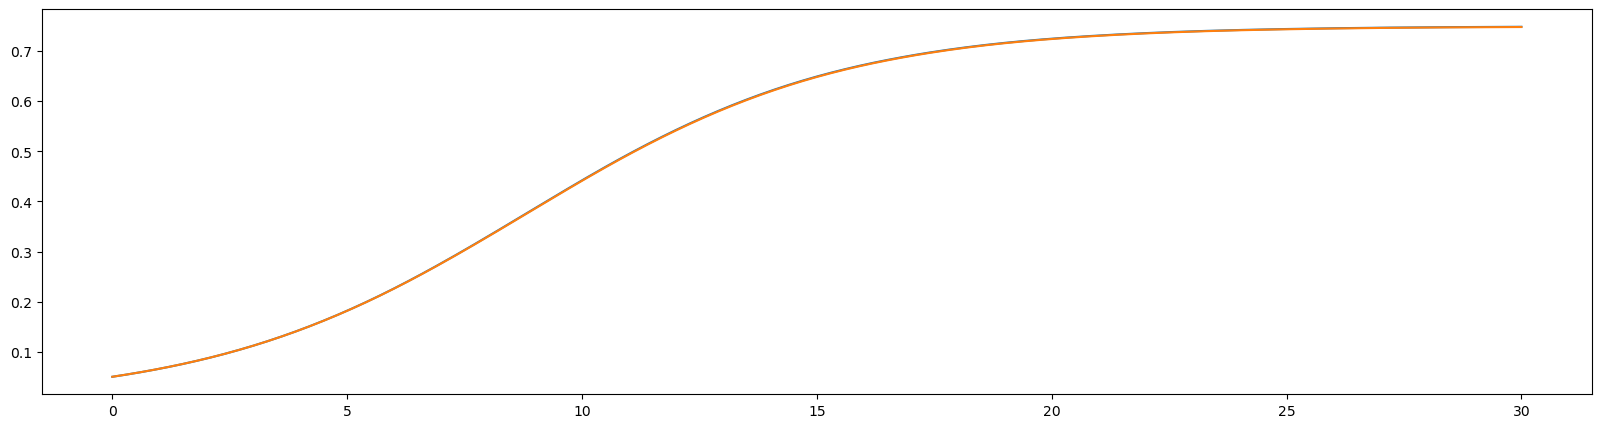

In [18]:
plt.figure(figsize=(20,5))
for grid in grids_constant:
    plt.plot(grid.grid_tensors[0], grid.grid_tensors_values)

In [19]:
grids_all = grids_oscillatory # + grids_constant


In [20]:
# Reformat the data into a format that can be used by the Kernel
smoothed_data = []
smoothed_derivatives = []
alphas_list = [[0], [1], [2]]
x_data = np.stack([grid.grid_tensors[0] for grid in grids_all])
# x_data += np.random.normal(0, 1e-2, x_data.shape)
# standardize x_data to mean 0 variance 1
x_mean = np.mean(x_data)
x_std = np.std(x_data)
x_data = (x_data - x_mean) / x_std
y_data = np.stack([grid.grid_tensors_values for grid in grids_all])
# y_data += np.random.normal(0, 1e-3, y_data.shape)
f_data = np.stack([grid.grid_tensors_forcing for grid in grids_all])

z, kdList, u_smoothed = KBio.kernel_smoothing(p, x_grid = x_data, u_data = y_data, f_data = f_data, alpha_list=alphas_list, nugget=1e-8)
# u_smoothed

Reshaping x_grid in smoother
(10, 301, 1)
n_grid_pts:  301


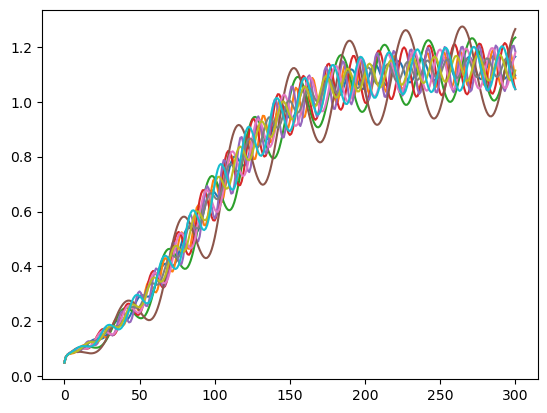

In [14]:
plt.plot(z)

<Figure size 1500x1500 with 0 Axes>

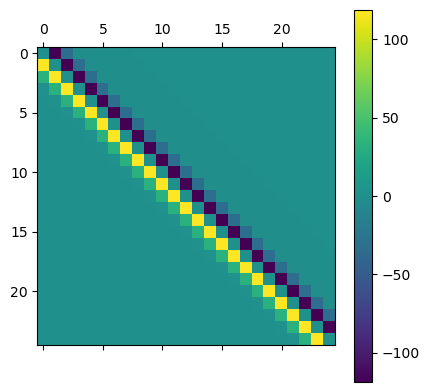

In [22]:
plt.figure(figsize=(15,15))
plt.matshow(kdList[1][0:25, 0:25])
plt.colorbar()
# plt.tight_layout()
plt.show()

In [23]:
print(p)

Gaussian with sigma 0.01


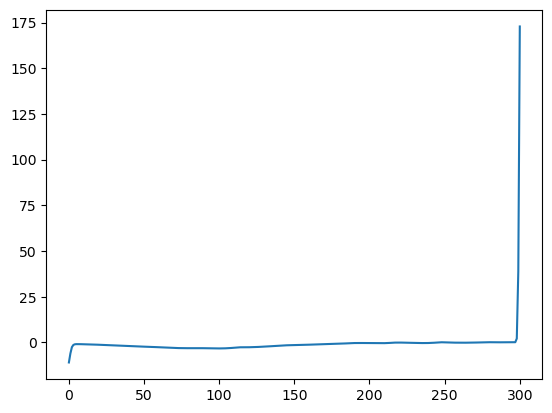

In [24]:
plt.plot(u_smoothed[1][:,3])

## Exploratory side-quest on the derivative matrices we just calculated.

Below are some plots used to verify that this method is working as intended.

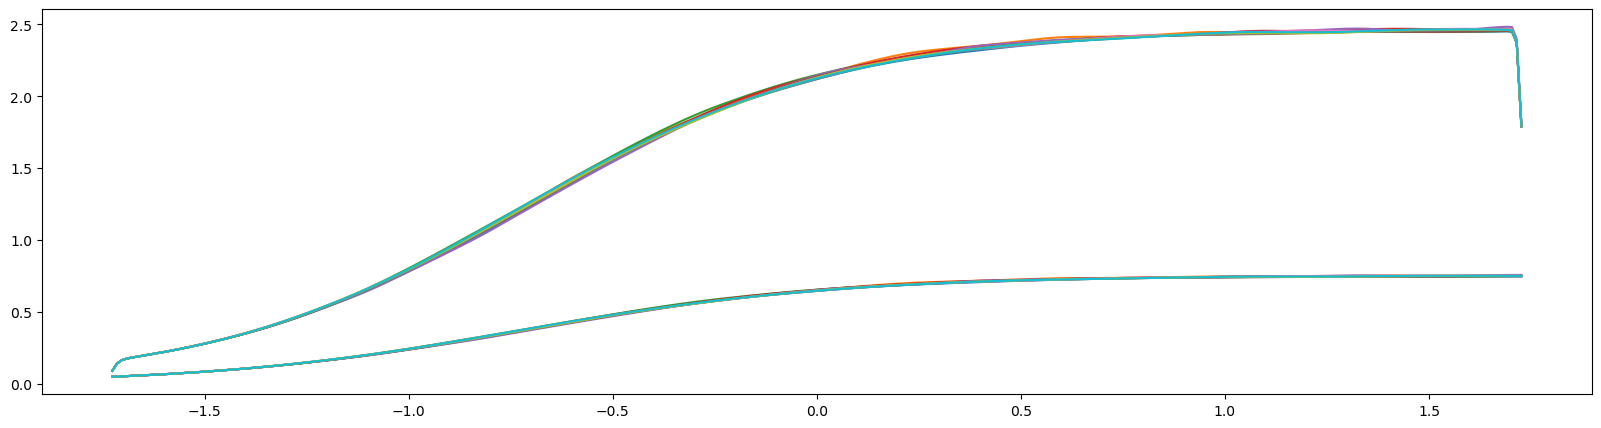

In [25]:
plt.figure(figsize=(20,5))
for grid in grids_oscillatory:
    plt.plot((grid.grid_tensors[0] - x_mean) / x_std, grid.grid_tensors_values, label='original')

plt.plot(x_data[0,:], u_smoothed[0], label='smoothed')
plt.show()
# plt.legend()

In [27]:
u_smoothed[0].shape

(301, 10)

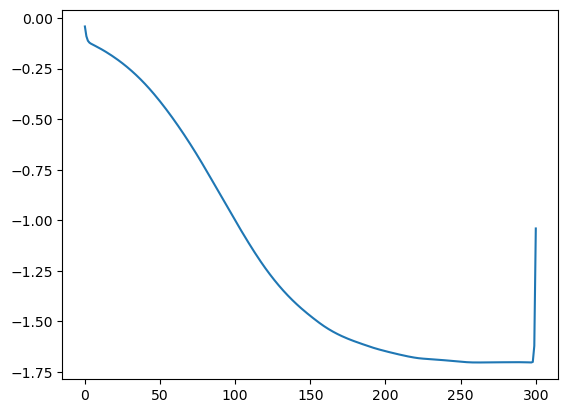

In [28]:
gap = grids_oscillatory[0].grid_tensors_values - u_smoothed[0][:,0]
plt.plot(gap)

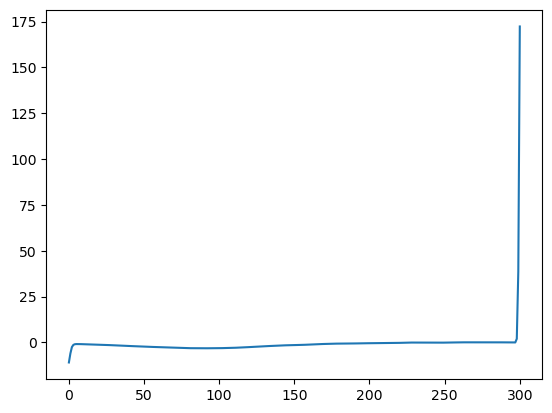

In [29]:
# plt.plot(u_smoothed[0][:,0])
plt.plot(u_smoothed[1][:,0])

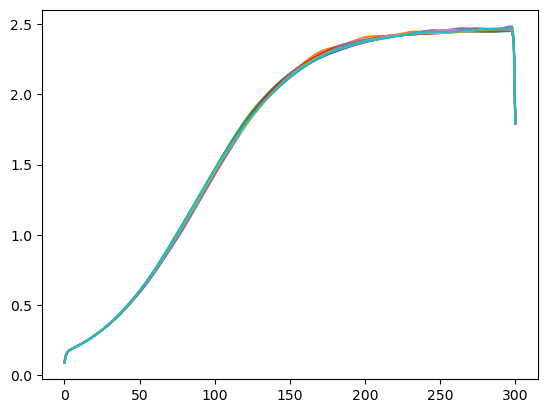

In [30]:
plt.plot(u_smoothed[0])
plt.show()

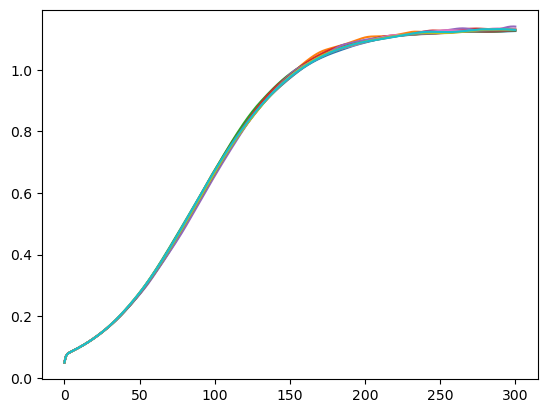

In [31]:
plt.plot(z)

In [32]:
kdList[1].shape

(301, 301)

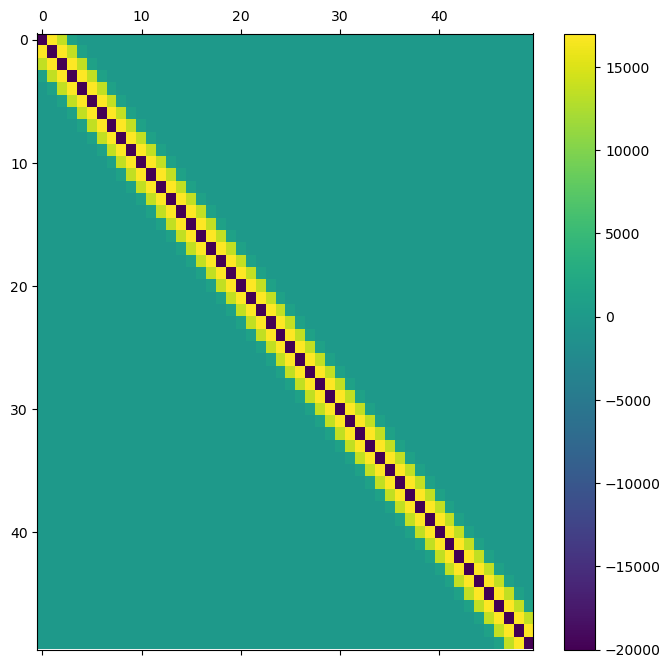

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
mappable = ax.matshow(kdList[2][0:50, 0:50])
ax.set_aspect('auto')
plt.colorbar(mappable)
plt.show()

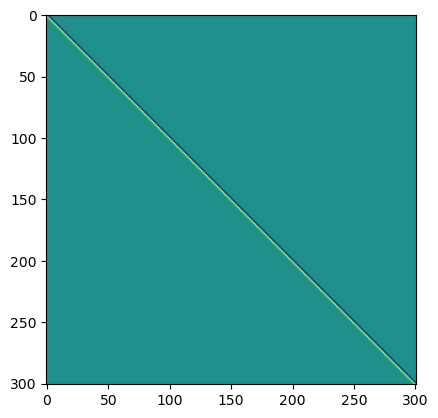

In [34]:
plt.imshow(kdList[1])

# Assemble derivative "features" at each grid point

In [35]:
feature_functions = []

def ident(index, x, u, u_deriv_list):
    """ Identity feature function for the $index$-th derivative of the function"""
    if np.abs(int(index) - index) > 1e-10:
        raise ValueError('Only the first derivative is available')
    if index == 0:
        return u
    else:
        return u_deriv_list[index]
# Get the first 2 derivatives and the function itself
for i in range(1,3):
    feature_functions.append(partial(ident, i))

# quadratic feature function
def quadratic(index, x, u, u_deriv_list):
    """ Quadratic feature function for the $index$-th derivative of the function

    The feature function is $u^2$ for the function itself and $2u u'$ for the first derivative.
    """

    if index == 0:
        return u**2
    elif index == 1:
        return 2*u*u_deriv_list[index]
    else:
        raise ValueError('Higher derivatives are not implemented')

feature_functions.append(partial(quadratic, 0))
# feature_functions.append(partial(quadratic, 1))

In [36]:
x_grid_list = grid.grid_list  # Get the grid of points as a list
F0 = KBio.assemble_features(x_grid_list=x_grid_list, u_smoothed=u_smoothed[0], multi_derivatives=u_smoothed, function_list=feature_functions)
# Reshape the feature tensor into a feature matrix, combining the first two dimensions
# Only FLATTEN the first two dimensions together.abs


# Below is the same as the above, just slower since we need to do a copy.
# # Now do it by for loops
# F1 = np.zeros((F.shape[0] * F.shape[1], F.shape[2]))
# for i in range(F.shape[0]):
#     for j in range(F.shape[1]):
#         F1[i*F.shape[1] + j] = F[i,j]

# labels/regression targets
f_data_flat = f_data.reshape(-1, 1)

In [73]:
feature_functions

[functools.partial(<function ident at 0x789c505e3380>, 1),
 functools.partial(<function ident at 0x789c505e3380>, 2),
 functools.partial(<function quadratic at 0x789c505e37e0>, 0)]

In [68]:
len(x_grid_list)

301

In [72]:
len(u_smoothed)

3

In [69]:
u_smoothed[0].shape

(301, 10)

In [37]:
# normalize F0 feature-wise, so that each feature has mean 0 and variance 1
F0_mean = np.mean(F0, axis=0)
F0_std = np.std(F0, axis=0)
F0 = np.divide((F0 - F0_mean), F0_std, where = (F0_std != 0))

In [38]:
F0_mean

array([ 1.50000000e+01,  1.71936446e+00,  1.71936446e+00, -6.76863690e-01,
        3.42497175e+04, -6.76863690e-01,  3.42497175e+04,  3.60726504e+00])

In [40]:
F0_std

array([8.68907360e+00, 8.06877251e-01, 8.06877251e-01, 1.03738645e+01,
       1.61698198e+04, 1.03738645e+01, 1.61698198e+04, 2.34256714e+00])

In [41]:
F0.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

We should use the F0 technique and just reshape, but in case we want to sanity check that it gives the natural ordering, we can do it manually.

In [42]:
q = KBio.Polynomial(degree=1, c=0)
# q = KBio.Gaussian(sigma=2e-1)

In [43]:
predictor, weight_vector = KBio.learn_DE_form(kernel=q, s_features=F0, f_labels=f_data_flat, nugget=1e-1)

In [44]:
predictor

<function KBio.kernelRoutines.learn_DE_form.<locals>.predictor(new_features)>

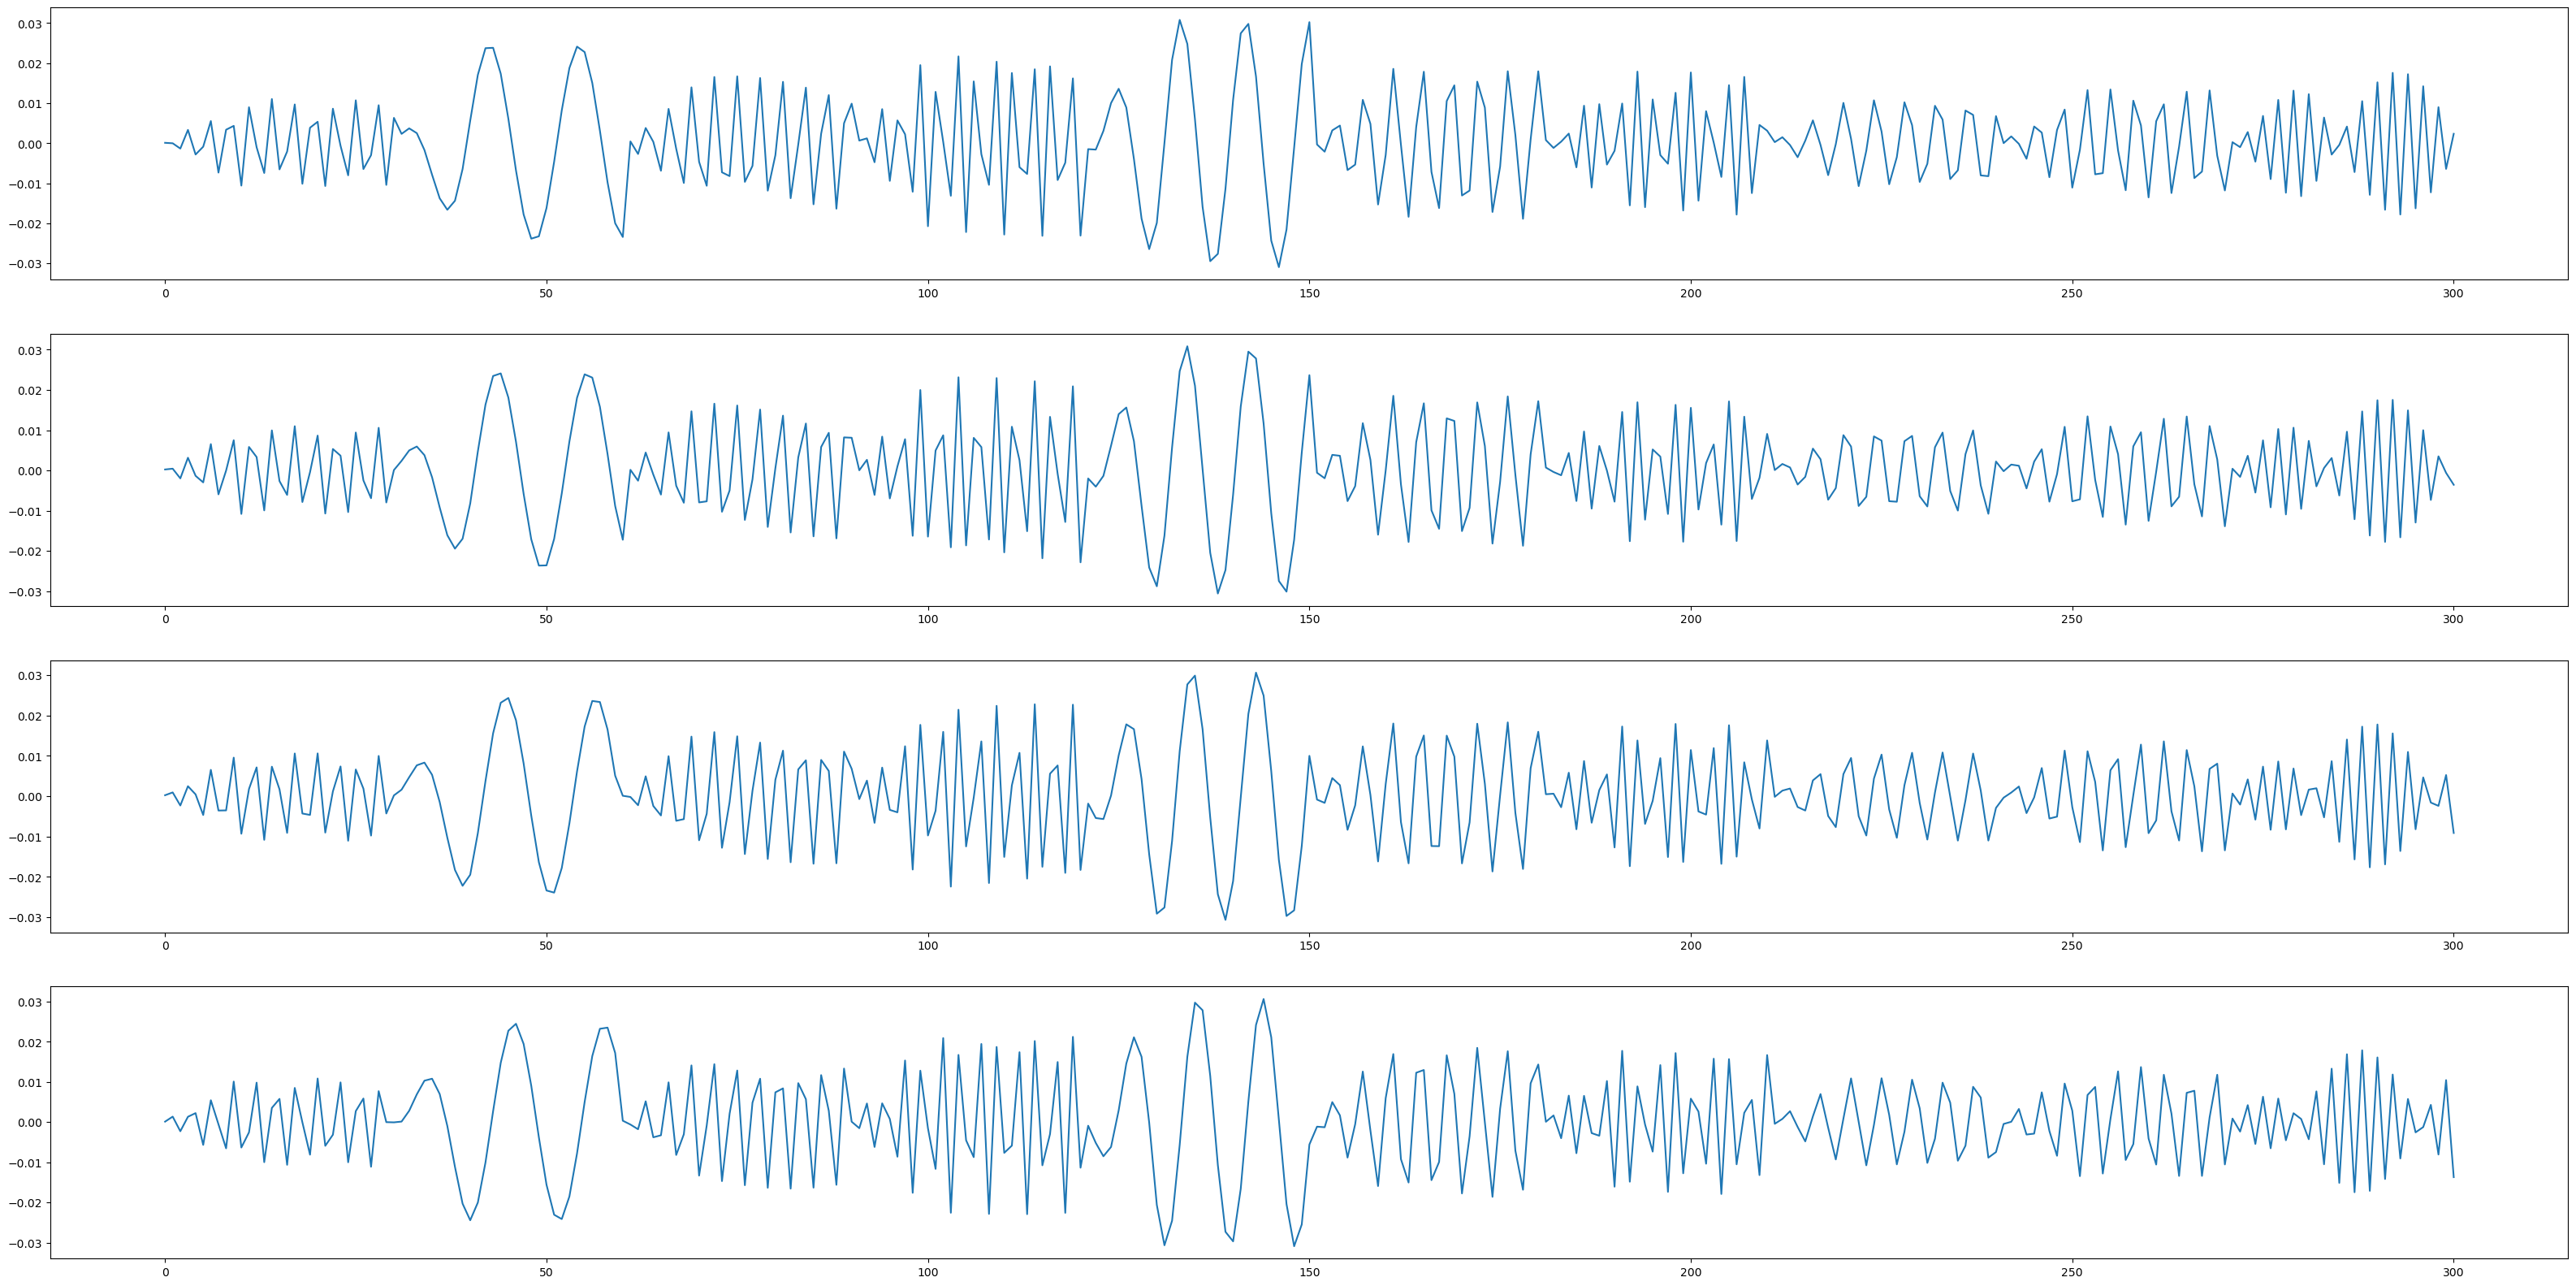

In [45]:
fig, ax = plt.subplots(4, 1, figsize=(40,20))
wv_matrix = weight_vector.reshape(301, weight_vector.shape[0] // 301)
for i in range(4):
    ax[i].plot(wv_matrix[:,i])

In [46]:
wv_matrix.shape

(301, 10)

In [47]:
weight_vector.shape

(3010, 1)

# Test out the technique on a set of new trajectories

In [48]:
# Repeat the above for a testing/validation set for demonstrations.

np.random.seed(1947)
n_samples_oscillatory_test = 6

amplitude_test = 10 ** (np.random.uniform(-3, -2.5, n_samples_oscillatory_test))
shift_test = np.random.uniform(0, np.pi, n_samples_oscillatory_test)
frequencies_test = np.random.uniform(1, 6, n_samples_oscillatory_test)

forcing_functions_test = [partial(oscillatory_forcing, amplitude, shift, frequency) for amplitude, shift, frequency in zip(amplitude_test, shift_test, frequencies_test)]
grids_oscillatory_test = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_oscillatory_test)]

for grid, amplitude, shift, frequency, fn in zip(grids_oscillatory_test, amplitude_test, shift_test, frequencies_test, forcing_functions_test):
    sim(grid, forcing = fn)


In [52]:
# Smooth this new data in the same way as before
x_data_test = np.stack([grid.grid_tensors[0] for grid in grids_oscillatory_test])
# x_data_test += np.random.normal(0, 1e-2, x_data_test.shape) # Add some noise to the x data
# Make sure we use the same scaling transform here as we did before.
x_data_test = (x_data_test - x_mean) / x_std
y_data_test = np.stack([grid.grid_tensors_values for grid in grids_oscillatory_test])

f_data_test = np.stack([grid.grid_tensors_forcing for grid in grids_oscillatory_test])

In [53]:
# Now smooth it
z_test, kdList_test, u_smoothed_test = KBio.kernel_smoothing(p, x_grid = x_data_test, u_data = y_data_test, f_data = f_data_test, alpha_list=alphas_list, nugget=1e-14)

Reshaping x_grid in smoother
(6, 301, 1)
n_grid_pts:  301


In [54]:
u_smoothed_test[0].shape

(301, 6)

In [63]:
x_grid_list

[(0.0,),
 (0.1,),
 (0.2,),
 (0.30000000000000004,),
 (0.4,),
 (0.5,),
 (0.6000000000000001,),
 (0.7000000000000001,),
 (0.8,),
 (0.9,),
 (1.0,),
 (1.1,),
 (1.2000000000000002,),
 (1.3,),
 (1.4000000000000001,),
 (1.5,),
 (1.6,),
 (1.7000000000000002,),
 (1.8,),
 (1.9000000000000001,),
 (2.0,),
 (2.1,),
 (2.2,),
 (2.3000000000000003,),
 (2.4000000000000004,),
 (2.5,),
 (2.6,),
 (2.7,),
 (2.8000000000000003,),
 (2.9000000000000004,),
 (3.0,),
 (3.1,),
 (3.2,),
 (3.3000000000000003,),
 (3.4000000000000004,),
 (3.5,),
 (3.6,),
 (3.7,),
 (3.8000000000000003,),
 (3.9000000000000004,),
 (4.0,),
 (4.1000000000000005,),
 (4.2,),
 (4.3,),
 (4.4,),
 (4.5,),
 (4.6000000000000005,),
 (4.7,),
 (4.800000000000001,),
 (4.9,),
 (5.0,),
 (5.1000000000000005,),
 (5.2,),
 (5.300000000000001,),
 (5.4,),
 (5.5,),
 (5.6000000000000005,),
 (5.7,),
 (5.800000000000001,),
 (5.9,),
 (6.0,),
 (6.1000000000000005,),
 (6.2,),
 (6.300000000000001,),
 (6.4,),
 (6.5,),
 (6.6000000000000005,),
 (6.7,),
 (6.800000000000

In [66]:
F0_test = KBio.assemble_features(x_grid_list=x_grid_list, u_smoothed=u_smoothed_test[0], multi_derivatives=u_smoothed_test, function_list=feature_functions, flatten=False)
# standardize the test data
F0_test = np.divide((F0_test - F0_mean), F0_std, where = (F0_std != 0))

In [67]:
F0_test.shape

(6, 301, 8)

In [57]:
s_test = np.zeros((F0_test.shape[1], F0_test.shape[1]))
for i in range(F0_test.shape[1]):
    for j in range(F0_test.shape[1]):
        s_test[i,j] = q(F0_test[0,i,:], F0_test[0,j,:] )
# s_test = q(F0_test[0,:,:], F0_test[0,:,:])

In [58]:
F0_test[0,1,:] - F0_test[0,2,:]

array([-0.01150871, -0.02908659, -0.02908659, -0.33459917, -0.06021463,
       -0.33459917, -0.06021463, -0.00307585])

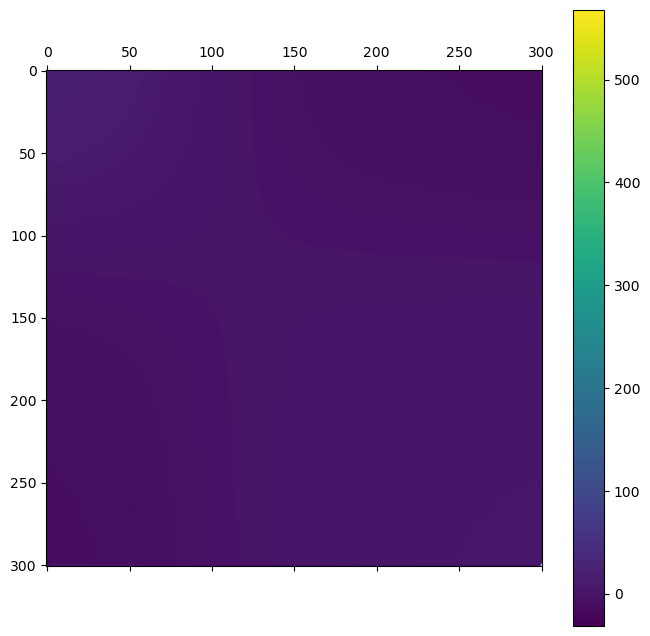

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
mappable = ax.matshow(s_test)
fig.colorbar(mappable)

In [60]:
F0_test[0,1,:].shape

(8,)

In [65]:
F0_test.shape

(6, 301, 8)

In [61]:
k_new, preds = predictor(F0_test[0,:,:])

(301, 3010) (3010, 1)


In [62]:
k_new.max()

572.3973978368132

/tmp/ipykernel_306932/3383889502.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


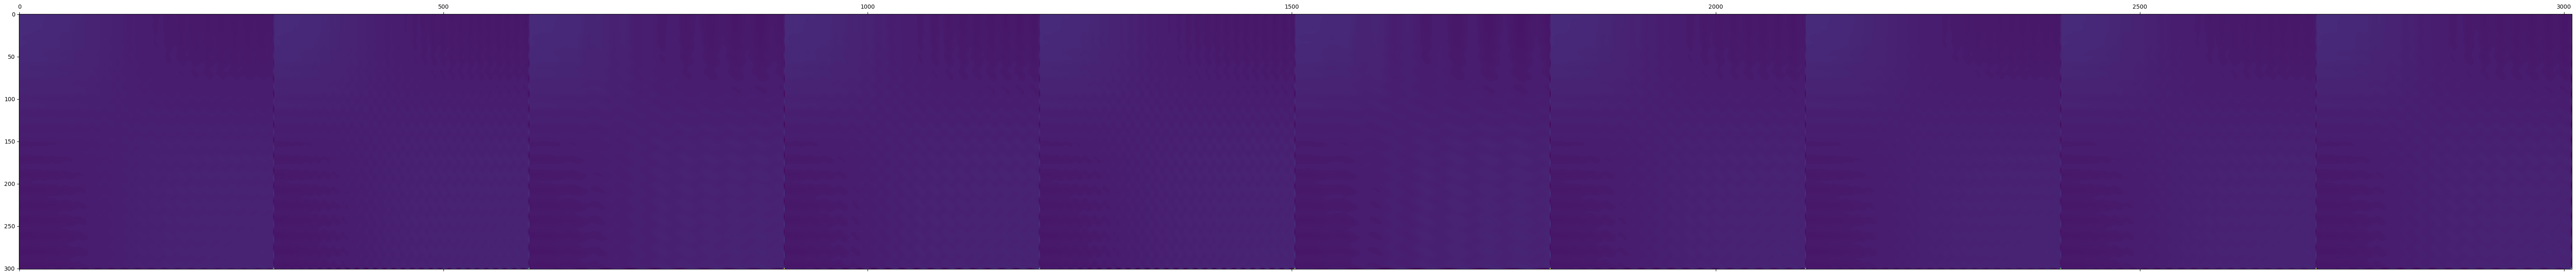

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(80, 10))
ax.matshow(k_new)
fig.show()

In [75]:
preds_all = []
for i in range(F0_test.shape[0]):
    print(i)
    k_new, preds = predictor(F0_test[i,:,:])
    preds_all.append(preds)

0
(301, 3010) (3010, 1)
1
(301, 3010) (3010, 1)
2
(301, 3010) (3010, 1)
3
(301, 3010) (3010, 1)
4
(301, 3010) (3010, 1)
5
(301, 3010) (3010, 1)


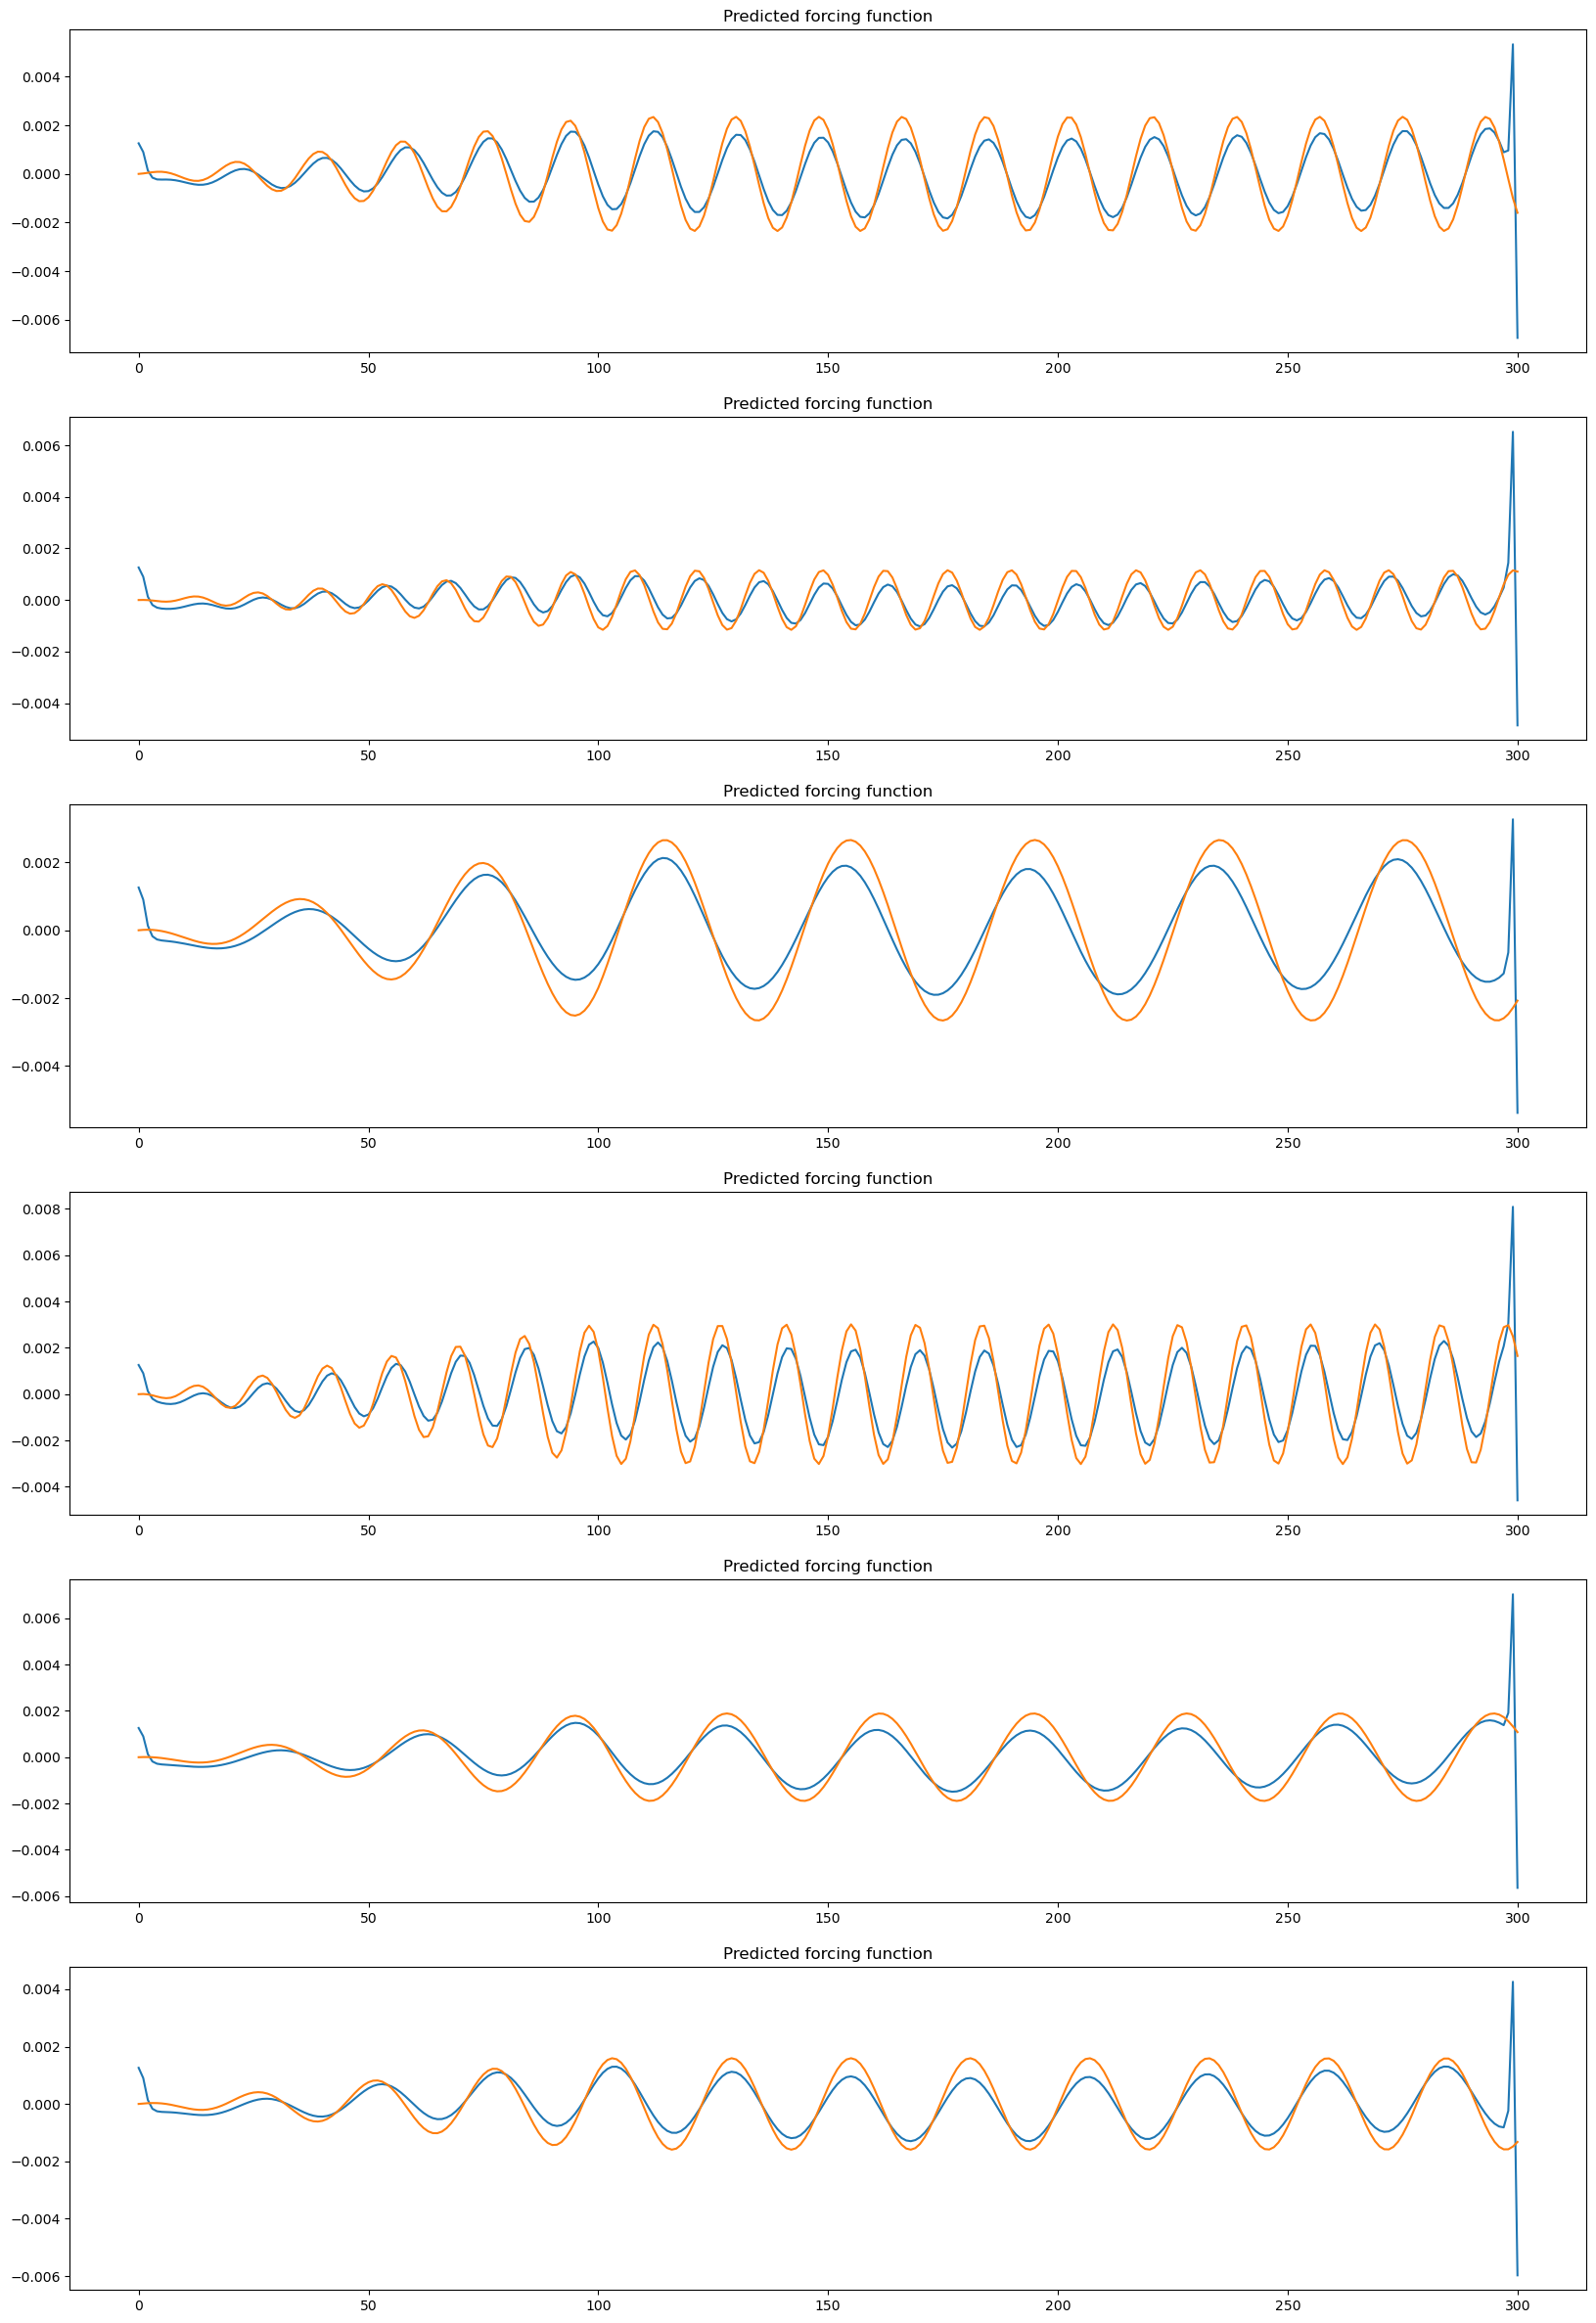

In [76]:

fig, ax = plt.subplots(n_samples_oscillatory_test, 1, figsize=(20,5 * n_samples_oscillatory_test))
for i in range(n_samples_oscillatory_test):
    ax[i].plot(preds_all[i], label='Predicted')
    ax[i].set_title("Predicted forcing function")
    ax[i].plot(f_data_test[i], label='True')